# Deep learning with Residual Networks

By Zhu Xiaochen (A0194512H) 

Previously we have shown that vanilla convolutional layers do not work because of vanishing gradients. So we use residual networks to fix that. However, our tests with ResNet seriously suffer from the overfitting issue. In this notebook, we experiments the following possible fixes:
1. Dropout layers
2. Data augmentation
3. Reducing model complexity

Unfortunately, none of these work for our dataset. In the next attempt (see notebook `deep_learning_resnet50`), we will try a more complicated model with pre-trained weights (from ImageNet).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

In [2]:
data_train = tfds.load("deep_weeds", with_info=False, split='train[20%:100%]').take(800)#.filter(lambda x: x['label'] != 8).take(800)
data_valid  = tfds.load("deep_weeds", with_info=False, split='train[0%:20%]').take(200)#.filter(lambda x: x['label'] != 8).take(160)

In [3]:
import math

def preprocess(dict):
  processed_image = dict['image'] / 255
  processed_label = dict['label']
  return processed_image, processed_label

# Use the batch method to prepare batches.
train_ds = (data_train
                .map(preprocess)
                .cache()
                # .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(32)
                .prefetch(tf.data.experimental.AUTOTUNE))

valid_ds = data_valid.map(preprocess).cache().batch(32)

## A residual network with 5 ResBlocks

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # for size in [64, 128]:
    for size in [64, 64, 128, 128, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(256,256,3), num_classes=9)

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [5]:
log = model.fit(
    train_ds, epochs=50, validation_data=valid_ds,
)

Epoch 1/50
25/25 [==============================] - 11s 270ms/step - loss: 1.6538 - accuracy: 0.4812 - val_loss: 2.1028 - val_accuracy: 0.5400
Epoch 2/50
25/25 [==============================] - 6s 239ms/step - loss: 1.2700 - accuracy: 0.5775 - val_loss: 2.0325 - val_accuracy: 0.5400
Epoch 3/50
25/25 [==============================] - 6s 239ms/step - loss: 1.0555 - accuracy: 0.6400 - val_loss: 1.9464 - val_accuracy: 0.5400
Epoch 4/50
25/25 [==============================] - 6s 238ms/step - loss: 0.7807 - accuracy: 0.7237 - val_loss: 1.8485 - val_accuracy: 0.5400
Epoch 5/50
25/25 [==============================] - 6s 240ms/step - loss: 0.4666 - accuracy: 0.8600 - val_loss: 1.7454 - val_accuracy: 0.5400
Epoch 6/50
25/25 [==============================] - 6s 241ms/step - loss: 0.3682 - accuracy: 0.8813 - val_loss: 1.7045 - val_accuracy: 0.5400
Epoch 7/50
25/25 [==============================] - 6s 240ms/step - loss: 0.2803 - accuracy: 0.9075 - val_loss: 1.6668 - val_accuracy: 0.5400
Epoch

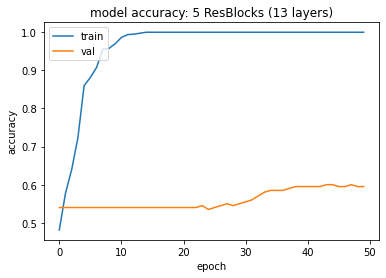

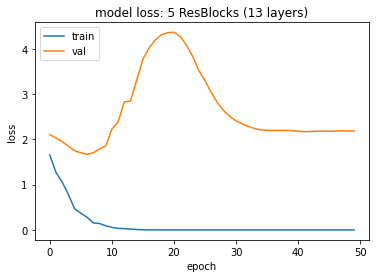

In [25]:
plt.plot(log.history['accuracy'])
plt.plot(log.history['val_accuracy'])
plt.title('model accuracy: 5 ResBlocks (13 layers)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('model loss: 5 ResBlocks (13 layers)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Data augmentation?

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# Use the batch method to prepare batches.
augmented_train_ds = (data_train
                .map(preprocess)
                .cache()
                .map(lambda x, y: (data_augmentation(x, training=True), y))
                .batch(32)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [22]:
# reiniialize the model

model = make_model(input_shape=(256,256,3), num_classes=9)

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

log_augmented = model.fit(
    augmented_train_ds, epochs=50, validation_data=valid_ds,
)

Epoch 1/50
25/25 [==============================] - 11s 394ms/step - loss: 1.5819 - accuracy: 0.5025 - val_loss: 2.1030 - val_accuracy: 0.5400
Epoch 2/50
25/25 [==============================] - 10s 394ms/step - loss: 1.4572 - accuracy: 0.5275 - val_loss: 2.0437 - val_accuracy: 0.5400
Epoch 3/50
25/25 [==============================] - 10s 393ms/step - loss: 1.3774 - accuracy: 0.5475 - val_loss: 1.9629 - val_accuracy: 0.5400
Epoch 4/50
25/25 [==============================] - 10s 395ms/step - loss: 1.2944 - accuracy: 0.5600 - val_loss: 1.9143 - val_accuracy: 0.5400
Epoch 5/50
25/25 [==============================] - 10s 398ms/step - loss: 1.2868 - accuracy: 0.5713 - val_loss: 1.8436 - val_accuracy: 0.5400
Epoch 6/50
25/25 [==============================] - 10s 386ms/step - loss: 1.2229 - accuracy: 0.5925 - val_loss: 1.8128 - val_accuracy: 0.5400
Epoch 7/50
25/25 [==============================] - 10s 387ms/step - loss: 1.1424 - accuracy: 0.6075 - val_loss: 1.8073 - val_accuracy: 0.5400

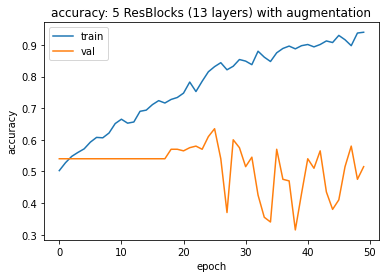

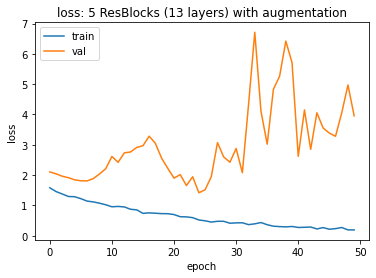

In [27]:
plt.plot(log_augmented.history['accuracy'])
plt.plot(log_augmented.history['val_accuracy'])
plt.title('accuracy: 5 ResBlocks (13 layers) with augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(log_augmented.history['loss'])
plt.plot(log_augmented.history['val_loss'])
plt.title('loss: 5 ResBlocks (13 layers) with augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## A simpler model?
Okay, maybe the previous residual network is just too complicated to cause overfitting issues. Let's try a simpler model.

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [64, 128]:
    # for size in [64, 64, 128, 128, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(256,256,3), num_classes=9)

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [29]:
log_simpler = model.fit(
    augmented_train_ds, epochs=50, validation_data=valid_ds,
)

Epoch 1/50
25/25 [==============================] - 11s 404ms/step - loss: 1.6172 - accuracy: 0.4613 - val_loss: 2.1285 - val_accuracy: 0.5400
Epoch 2/50
25/25 [==============================] - 10s 404ms/step - loss: 1.3952 - accuracy: 0.5238 - val_loss: 2.0897 - val_accuracy: 0.5400
Epoch 3/50
25/25 [==============================] - 10s 400ms/step - loss: 1.3554 - accuracy: 0.5462 - val_loss: 2.0722 - val_accuracy: 0.5400
Epoch 4/50
25/25 [==============================] - 10s 407ms/step - loss: 1.2720 - accuracy: 0.5838 - val_loss: 2.0425 - val_accuracy: 0.5400
Epoch 5/50
25/25 [==============================] - 10s 409ms/step - loss: 1.2569 - accuracy: 0.5675 - val_loss: 2.0284 - val_accuracy: 0.5400
Epoch 6/50
25/25 [==============================] - 10s 408ms/step - loss: 1.2088 - accuracy: 0.5850 - val_loss: 1.9937 - val_accuracy: 0.5400
Epoch 7/50
25/25 [==============================] - 10s 395ms/step - loss: 1.1770 - accuracy: 0.6087 - val_loss: 1.9582 - val_accuracy: 0.5400

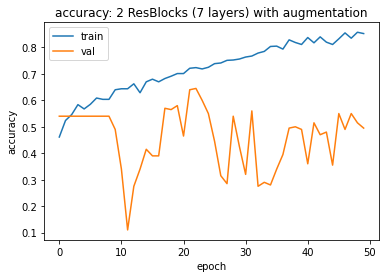

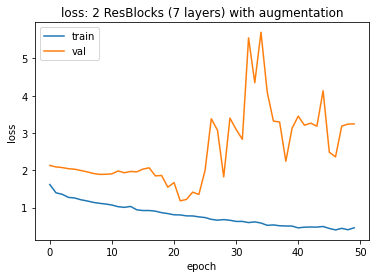

In [30]:
plt.plot(log_simpler.history['accuracy'])
plt.plot(log_simpler.history['val_accuracy'])
plt.title('accuracy: 2 ResBlocks (7 layers) with augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(log_simpler.history['loss'])
plt.plot(log_simpler.history['val_loss'])
plt.title('loss: 2 ResBlocks (7 layers) with augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()